In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install face_recognition library
!pip3 install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=ecfcb5faad2b5ec78e0b46c80e349174c4946991729b189c4311716b6f04b0f9
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/FF_REAL_Face_only_data2-20240603T170319Z-001.zip"

extract_dir = "/content/your_extract_directory"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
import glob
# preprocessed train dataset files paths
video_files =  glob.glob('/content/your_extract_directory/FF_FAKE_Face_only_data-y2/*.mp4')
video_files +=  glob.glob('/content/your_extract_directory/FF_FAKE_Face_only_data2/*.mp4')
video_files +=  glob.glob('/content/your_extract_directory/FF_REAL_Face_only_data2/*.mp4')
len(video_files)

1849

In [ ]:
import json
import glob
import numpy as np
import cv2
import copy
import random

random.shuffle(video_files)

frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

print("Training Videos: ")
print("Total no of video: " , len(frame_count))
print('Average frame per video:', np.mean(frame_count))

Training Videos: 
Total no of video:  1518
Average frame per video: 134.8820816864295


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import face_recognition

class video_dataset(Dataset):
  """
  this class accepts preprocessed video dataset as input, extracts the faces from
  each of the video, recognizes the faces and stacks the extracted frames together
  """
  def __init__(self,video_names,labels,sequence_length = 60,transform = None):
      self.video_names = video_names
      self.labels = labels
      self.transform = transform
      self.count = sequence_length

  def __len__(self):
      return len(self.video_names)

  def __getitem__(self,idx):
      video_path = self.video_names[idx]
      frames = []
      a = int(100/self.count)
      first_frame = np.random.randint(0,a)
      temp_video = video_path.split('/')[-1]
      label = self.labels.iloc[(labels.loc[labels["filename"] == temp_video].index.values[0]),1]
      if(label == 'FAKE'):
        label = 0
      if(label == 'REAL'):
        label = 1
      for i,frame in enumerate(self.frame_extract(video_path)):
        frames.append(self.transform(frame))
        if(len(frames) == self.count):
          break
      frames = torch.stack(frames)
      frames = frames[:self.count]
      return frames, label

  def frame_extract(self,path):
    vidObj = cv2.VideoCapture(path)
    success = 1
    while success:
        success, image = vidObj.read()
        if success:
            yield image

def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
def number_of_real_and_fake_videos(data_list):
  lab = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)

  fake = 0
  real = 0

  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["filename"] == temp_video].index.values[0]),1]

    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real, fake

train :  844
test :  839
TRAIN:  Real: 413  Fake: 431


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TEST:  Real: 412  Fake: 427


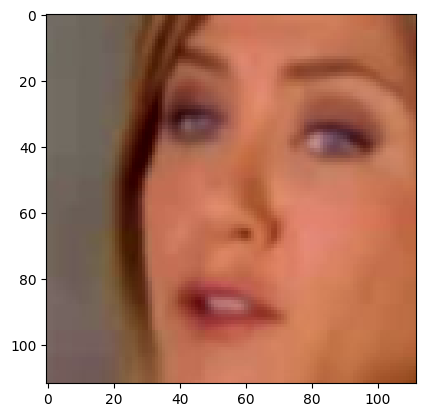

In [ ]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["filename","label"]
labels = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)

train_videos = video_files[:int(0.502*len(video_files))]
valid_videos = video_files[int(0.502*len(video_files)):]

print("train : " , len(train_videos))
print("test : " , len(valid_videos))

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])

im_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# tranform both train and val datasets
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((im_size,im_size)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])

train_data = video_dataset(train_videos, labels, sequence_length = 10, transform = train_transforms)
val_data = video_dataset(valid_videos, labels, sequence_length = 10, transform = train_transforms)
# load the data into dataloader and create batches and num of workers
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 4)
valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 4)

image,label = train_data[0]
im_plot(image[0,:,:,:])

ResNet50

In [ ]:
from torch import nn
from torchvision import models
class Model(nn.Module):
  """
  Base class for all neural network modules.
  Ensemble model of resnet and lstm is built
  We use of a 2048-wide LSTM unit with 0.4 dropout.
  LSTM model takes a sequence of 2048 dimensional ImageNet feature vectors.
  The LSTM is followed by a 512 fully-connected layer
  """
  def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
      super(Model, self).__init__()
      model = models.resnet50(pretrained = True) #Residual Network CNN
      self.model = nn.Sequential(*list(model.children())[:-2])
      self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
      self.relu = nn.LeakyReLU()
      self.dp = nn.Dropout(0.4)
      self.linear1 = nn.Linear(2048,num_classes)
      self.avgpool = nn.AdaptiveAvgPool2d(1)
  def forward(self, x):
      batch_size,seq_length, c, h, w = x.shape
      x = x.view(batch_size * seq_length, c, h, w)
      fmap = self.model(x)
      x = self.avgpool(fmap)
      x = x.view(batch_size,seq_length,2048)
      x_lstm,_ = self.lstm(x,None)
      return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))


In [ ]:
model = Model(2).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.1MB/s]


In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys

# train and validate the model and caluclate loss, accuracy using AverageMeter()
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
        # save the trained model as a checkpoint
    torch.save(model.state_dict(),'/content/drive/MyDrive/checkpointsResNet101/resnet50_16k.pt')
    return losses.avg,accuracies.avg

def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

class AverageMeter(object):
  def __init__(self):
      self.reset()
  def reset(self):
      self.val = 0
      self.avg = 0
      self.sum = 0
      self.count = 0

  def update(self, val, n=1):
      self.val = val
      self.sum += val * n
      self.count += n
      self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size


In [ ]:
import seaborn as sn
# Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  """ Plot train and validation loss"""
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  """ Plot train and validation accuracy"""
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 210 / 211] [Loss: 0.683105, Acc: 57.82%]Testing
[Batch 209 / 210]  [Loss: 0.609340, Acc: 64.96%]
Accuracy 64.95828367103695
[Epoch 2/20] [Batch 210 / 211] [Loss: 0.549484, Acc: 74.88%]Testing
[Batch 209 / 210]  [Loss: 0.424118, Acc: 83.19%]
Accuracy 83.19427890345649
[Epoch 3/20] [Batch 210 / 211] [Loss: 0.410833, Acc: 84.36%]Testing
[Batch 209 / 210]  [Loss: 0.352536, Acc: 84.74%]
Accuracy 84.74374255065554
[Epoch 4/20] [Batch 210 / 211] [Loss: 0.391839, Acc: 86.37%]Testing
[Batch 209 / 210]  [Loss: 0.294729, Acc: 86.41%]
Accuracy 86.41239570917759
[Epoch 5/20] [Batch 210 / 211] [Loss: 0.373575, Acc: 87.20%]Testing
[Batch 209 / 210]  [Loss: 0.268486, Acc: 88.32%]
Accuracy 88.31942789034565
[Epoch 6/20] [Batch 210 / 211] [Loss: 0.377892, Acc: 88.86%]Testing
[Batch 209 / 210]  [Loss: 0.270751, Acc: 88.32%]
Accuracy 88.31942789034565
[Epoch 7/20] [Batch 210 / 211] [Loss: 0.310853, Acc: 90.64%]Testing
[Batch 209 / 210]  [Loss: 0.283943, Acc: 87.01%]
Accuracy 87.0083432

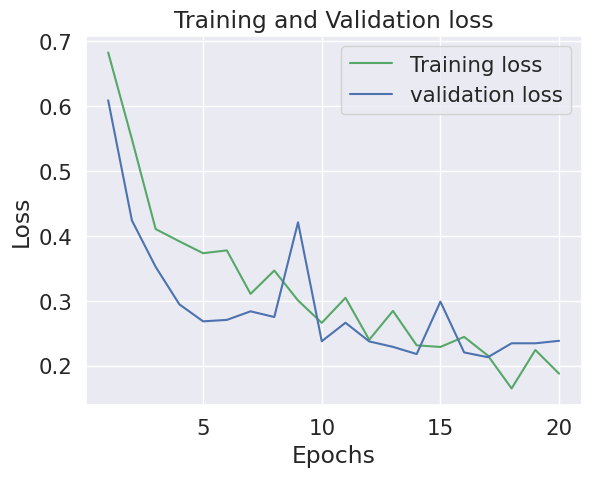

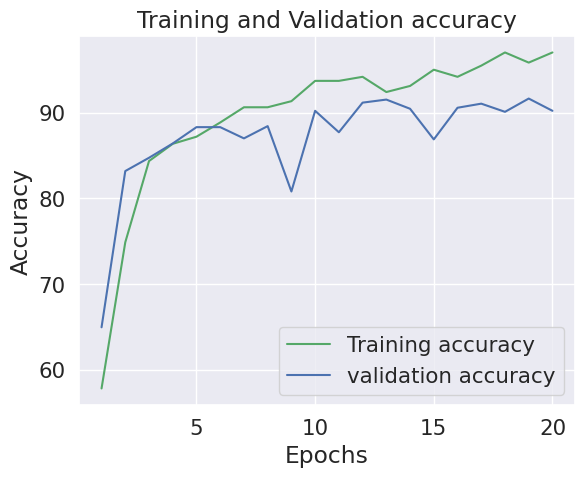

[[402  25]
 [ 57 355]]
True positive =  402
False positive =  25
False negative =  57
True negative =  355




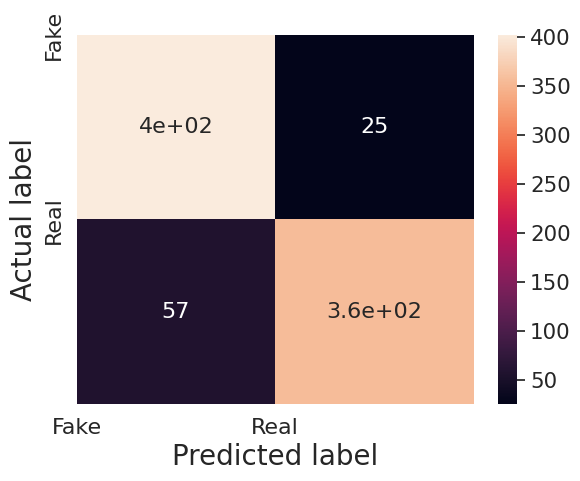

Calculated Accuracy 90.2264600715137


In [ ]:
from sklearn.metrics import confusion_matrix
lr = 1e-5 #0.001
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)